## Curve-fitting


* Let's create a simulated observation of a stellar spectrum
* It is a Planck function (blackbody) with unknown temperature and unknown distance from us
* The flux we observe at a given wavelength is proportional to $B_\lambda(T) / (4 \pi d^2)$
* We will create some fake data for a model with $T = 3000$ K, $d = 1$ (arbitrary units)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
h = 6.626e-34
c = 3.0e+8
k = 1.38e-23

def planck(wav, T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity


In [2]:
Temperature = 3000 # kelvin
distance = 1 # the units don't matter for this example -- point is that flux is proportional to 1/distance**2
wavelengthVals = np.linspace(1e-10,1e-5,1000)

theoryCurve = planck(wavelengthVals, Temperature) / distance**2

/opt/python/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp


Populating the interactive namespace from numpy and matplotlib


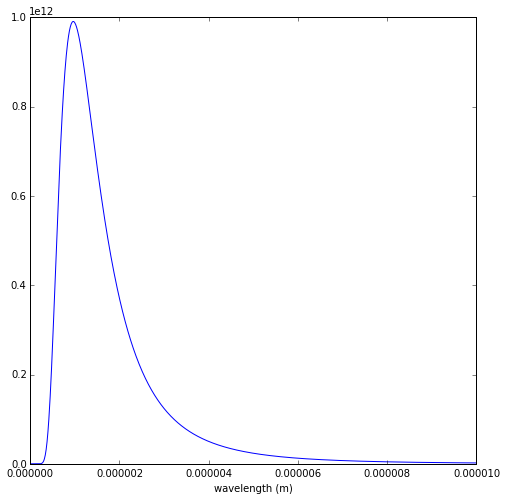

In [3]:
%pylab inline
plt.figure(figsize = (8,8))
plt.plot(wavelengthVals, theoryCurve)
plt.xlabel('wavelength (m)')
plt.show()

* Now we make the fake data 
* 30 data points with a fair amount of noise

In [28]:

nDataPts = 30
noiseRMS = .3e12
spectrumLambdaVals   = np.linspace(1e-10,.4e-5,nDataPts)

#evalute theory curve and add Gaussian noise.
spectrumFluxVals = planck(spectrumLambdaVals, Temperature) / distance**2 + noiseRMS * random.randn(nDataPts)





/opt/python/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp


Let's plot our data on its own

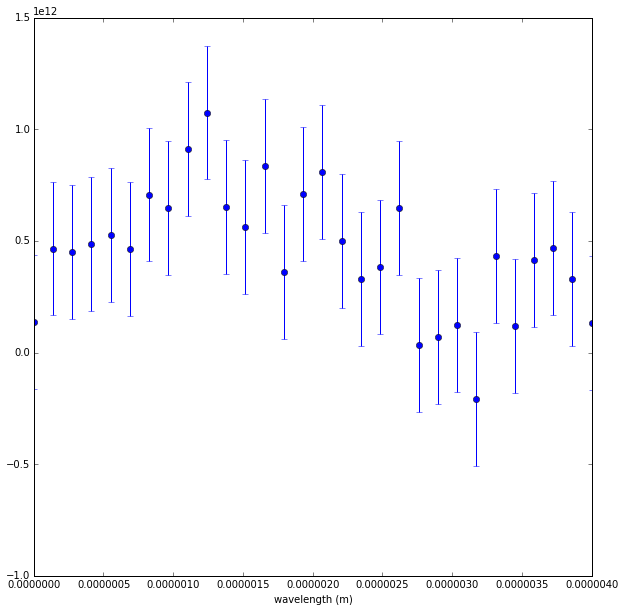

In [29]:
figure(figsize = (10,10))
clf()
errorbar(spectrumLambdaVals, spectrumFluxVals, noiseRMS, fmt = 'o')
xlabel('wavelength (m)')

We could set up a chi-square statistic and find the minimum... but let's find values of chi-square on a grid of points in the 2d space of temperature and distance.

First we generate a grid of theory curves, one for each combination of $d$ and $T$

In [30]:



nTempVals = 60
nDistVals = 50
temperatures = linspace(2e3, 4e3, nTempVals)
theoryGrid = numpy.zeros((nTempVals, nDistVals, nDataPts))
distances = linspace(1e-2, 2., nDistVals)

for i in arange(nTempVals):
    for j in arange(nDistVals):
        theoryGrid[i, j, :] = planck(spectrumLambdaVals, temperatures[i]) / distances[j]**2
        
        
        
        

/opt/python/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp


Now plot all our theory cuves, together with the data.  Most of them will not be good fits

(-1000000000000.0, 3000000000000.0)

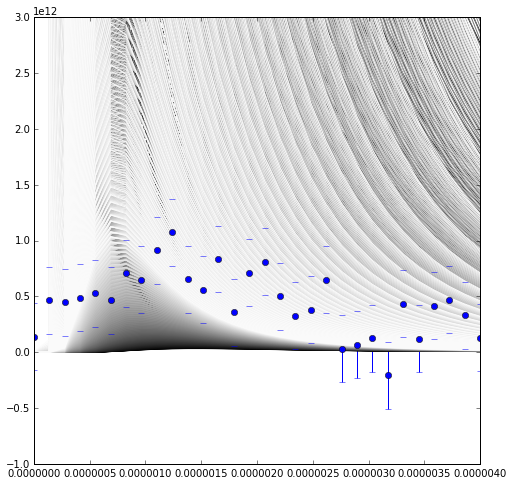

In [31]:
figure(figsize = (8,8))
clf()


for i in arange(nTempVals):
    for j in arange(nDistVals):
        plot(spectrumLambdaVals, theoryGrid[i,j,:], color = '%f' %(i / float(nTempVals)))
errorbar(spectrumLambdaVals, spectrumFluxVals, noiseRMS, fmt = 'o')
        
ylim(-1e12,3e12)

Now we will compute $\chi^2$ at each point in the 2d space.

In [32]:
chi2grid = numpy.zeros((nTempVals, nDistVals))
for i in arange(nTempVals):
    for j in arange(nDistVals):
        chi2grid[i, j] = (((spectrumFluxVals - theoryGrid[i,j,:]) / noiseRMS)**2).sum()

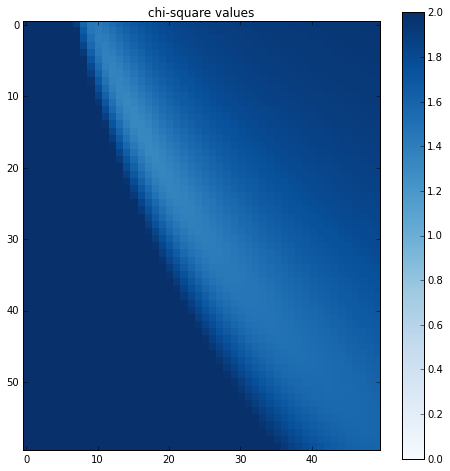

In [33]:
figure(figsize = (8,8))
imshow(((log10(chi2grid))), cmap = 'Blues', interpolation = 'nearest')#, \
#       extent = [temperatures.min(), temperatures.max(), distances.min(), distances.max()],aspect=1)
clim(0,2)
colorbar()


#gca().xaxis.set_ticks( arange(temperatures.min(), temperatures.max(), 10))
#gca().yaxis.set_ticks( arange(distances.min(), distances.max(), (distances.max() - distances.min()) / 10))


title('chi-square values')

A plot with all curves for which chi2 changes by 9

(0, 1200000000000.0)

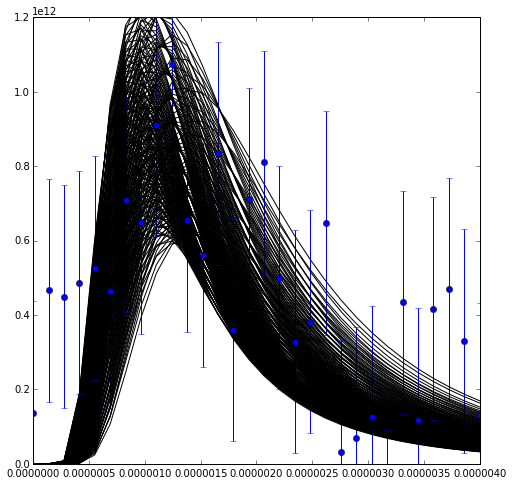

In [34]:
figure(figsize = (8,8))
clf()


for i in arange(nTempVals):
    for j in arange(nDistVals):
        if abs(chi2grid[i,j] - chi2grid.min() ) < 9:
            plot(spectrumLambdaVals, theoryGrid[i,j,:], color = 'k')

        
errorbar(spectrumLambdaVals, spectrumFluxVals, noiseRMS, fmt = 'o')
        
ylim(0,1.2e12)

Now we find the best-fitting temperature and distance

In [35]:
bestfit = unravel_index(argmin(chi2grid), chi2grid.shape)


In [36]:

bestfit

(15, 16)

In [39]:
temperatures[bestfit[0]], distances[bestfit[1]]

(2508.4745762711864, 0.65979591836734697)

This doesn't mean much without errors on the parameters -- let's find these.

In [40]:
probability = exp(-  (chi2grid - chi2grid.min())/2)
probability /= sum(probability)

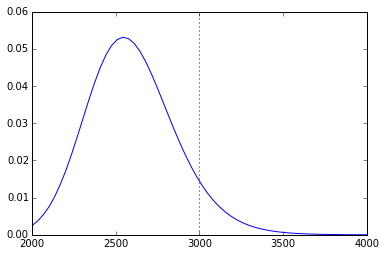

In [41]:

oneDtemp = sum(probability, axis = 1)

plot(temperatures, oneDtemp)
axvline(Temperature, ls = ':')


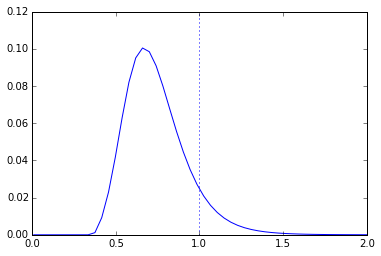

In [42]:

oneDdistance = sum(probability, axis = 0)

plot(distances, oneDdistance)
axvline(distance, ls = ':')


<matplotlib.colorbar.Colorbar instance at 0x7f78d4a87b48>

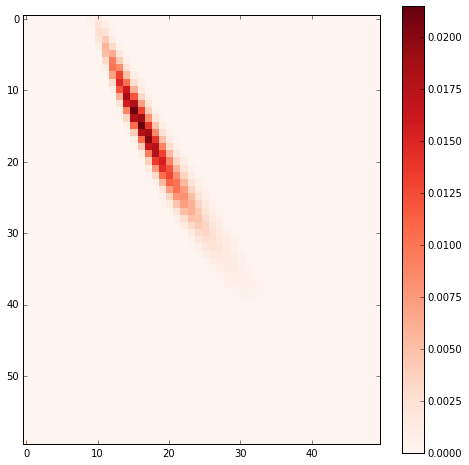

In [43]:
figure(figsize = (8,8))
imshow(probability,cmap='Reds', interpolation = 'nearest')
colorbar()

In [44]:
nps = 500
prob_vector = linspace(0,1,nps)
area = zeros(nps)
for i in arange(nps):
    ppixs = where(probability >= prob_vector[i])
    area[i] = (probability[ppixs]).sum()
  
import scipy.interpolate
area68 = (scipy.interpolate.interp1d(area, prob_vector))(.68)
area95 = (scipy.interpolate.interp1d(area, prob_vector))(.95)

area99 = (scipy.interpolate.interp1d(area, prob_vector))(.997)

In [45]:
print area68, area95


0.00608946219646 0.000862296427635


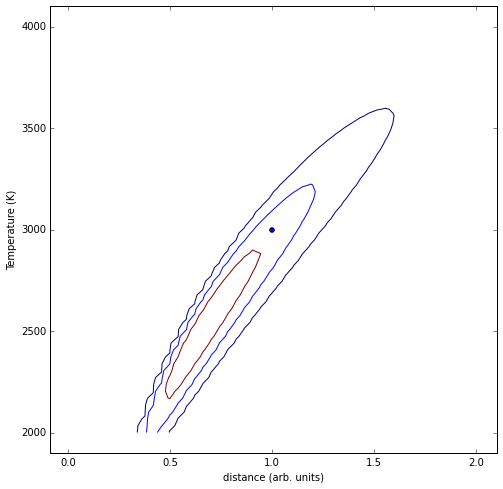

In [46]:

figure(figsize = (8,8))
t, d = np.meshgrid(distances, temperatures)

contour(t, d, probability, [area99,area95, area68])
scatter([distance], [Temperature])
xlabel('distance (arb. units)')
ylabel('Temperature (K)')

In [47]:
def fitFunction(Wavelength, Temperature, distance): 
    return planck(Wavelength, Temperature) / distance**2

In [48]:
from scipy import optimize
params, covariance = scipy.optimize.curve_fit(fitFunction, spectrumLambdaVals, \
                         spectrumFluxVals, p0 = [2000.,.5],sigma=noiseRMS * ones(nDataPts))


/opt/python/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp


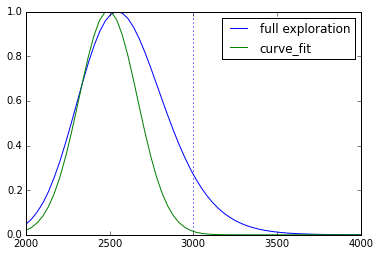

In [49]:
temperatureOutput = 1./sqrt(2*np.pi*covariance[0,0]) * exp(-(temperatures - params[0])**2 / (2 * covariance[0,0]))

plot(temperatures, oneDtemp / max(oneDtemp) , label = 'full exploration')
axvline(Temperature, ls = ':')
                                                           
                                                           
plot(temperatures, temperatureOutput / max(temperatureOutput), label='curve_fit')
legend(loc='best')

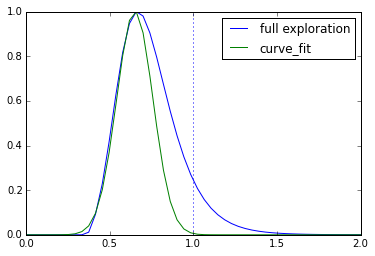

In [50]:
distanceOutput = 1./sqrt(2*np.pi*covariance[1,1]) * exp(-(distances - params[1])**2 / (2 * covariance[1,1]))

plot(distances,  oneDdistance / max(oneDdistance) , label = 'full exploration')
axvline(distance, ls = ':')
                                                           
                                                           
plot(distances, distanceOutput / max(distanceOutput), label='curve_fit')
legend(loc = 'best')